<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_%EA%B0%9C%EC%A0%952%ED%8C%90_ch9_5~6_p_601_625.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트

TMDB 5000 영화 데이터 세트 : 유명한 영화 데이터 정보 사이트인 IMDB의 많은 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 캐글에서 제공하는 데이터 세트

### 장르 속성을 이용한 영화 콘텐츠 기반 필터링

콘텐츠 기반 필터링
- 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
- 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 하는 방식

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


- 4803개의 레코드와 20개의 피처로 구성
- 영화 제목, 개요, 인기도, 평점, 투표수, 예산, 키워드 등 영화에 대한 다양한 메타 정보를 가지고 있음

- 이 중 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출해 새롭게 DataFrame으로 생

In [3]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                    'keywords', 'overview']]

- `tmdb_5000_movies` 데이터셋의 `genres`와 `keywords` 칼럼은 파이썬 리스트 안에 여러 개의 딕셔너리가 있는 문자열 형태로 저장

->  따라서 이 칼럼들을 분석에 활용하려면 먼저 문자열을 파이썬 객체로 변환(parsing) 하는 전처리가 필요

In [4]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


- `genres`와 `keywords` 칼럼은 문자열로 된 `list[dict]` 구조  
- 각 딕셔너리에서 `'name'` 키를 통해 장르 또는 키워드 이름 추출 가능  
- `ast.literal_eval()` 함수를 `apply()`와 함께 사용해 문자열을 실제 리스트 객체로 변환  

In [5]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

- `genres` 칼럼: 리스트 형태의 딕셔너리 객체로 변환 완료  
- `'name'` 키 값만 추출하기 위해 `apply(lambda x: [d['name'] for d in x])` 사용  
- 장르명 리스트로 구성된 새로운 Series 생성

In [6]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


# 장르 콘텐츠 유사도 측정

1. **genres 칼럼 전처리**  
   - 리스트 형태의 장르명을 `' '.join(리스트)`로 문자열 변환 → `genres_literal` 생성

2. **피처 벡터화**  
   - `CountVectorizer` 사용 → `genres_literal`을 단어 빈도 기반 벡터로 변환

3. **유사도 계산**  
   - `cosine_similarity`로 영화 간 장르 유사도 행렬 계산

4. **영화 추천**  
   - 유사도 높은 영화들 중에서 **평점 높은 순**으로 추천



- `genres` 칼럼: 리스트 객체로 구성됨 (예: `['Action', 'Adventure', 'Fantasy']`)  
- 문자열로 변환: `apply(lambda x: ' '.join(x))` 사용  
- 변환된 문자열을 `genres_literal` 칼럼에 저장  
- `CountVectorizer`로 `genres_literal` 칼럼을 피처 벡터화하여 행렬 생성  

In [7]:
from operator import ge
from sklearn.feature_extraction.text import CountVectorizer

# Countvectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=1, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- `CountVectorizer`로 피처 벡터 행렬을 만든 후, `cosine_similarity()`로 영화 간 유사도를 계산

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


- `cosine_similarity()`로 생성된 `genre_sim` 객체는 영화 간 장르 유사도 정보를 담고 있음  
- `movies_df`의 각 레코드에 대해 장르 유사도가 높은 영화들을 추출  
- `genre_sim`을 이용해 콘텐츠 기반 필터링 수행

- `genre_sim` 객체에서 행별로 유사도 값이 높은 순으로 정렬된 위치 인덱스 추출  
- `argsort()[:, ::-1]`로 유사도 높은 순으로 정렬된 인덱스 값을 얻음

In [10]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0   46 3494 ... 3331 3333 2031]]


- 0번 레코드와 가장 유사한 레코드: 3494번  
- 두 번째로 유사한 레코드: 813번  
- 가장 유사도가 낮은 레코드: 2401번

# 장르 콘텐츠 필터링을 이용한 영화 추천

장르 유사도에 따라 영화를 추천하는 함수를 생성

In [11]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):

  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_name을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

- find_sim_movie() 함수를 이용해 영화 '대부'와 장르별로 유사한 영화 10개를 추천

In [12]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[1881 3378 3866 1370 1464  588 3887 3594 2839  892]]


,title,vote_average
1881,The Shawshank Redemption,8.5
3378,Auto Focus,6.1
3866,City of God,8.1
1370,21,6.5
1464,Black Water Transit,0.0
588,Wall Street: Money Never Sleeps,5.8
3887,Trainspotting,7.8
3594,Spring Breakers,5.0
2839,Rounders,6.9
892,Casino,7.8


- 많은 후보군을 선정한 뒤 평점(`vote_average`)으로 필터링하여 최종 추천  
- 소수의 관객이 높은 평점을 부여해 왜곡된 데이터 가능성 확인  
- `sort_values()`로 평점 분포 확인

In [13]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
4662,Little Big Top,10.0,1
3519,Stiff Upper Lips,10.0,1
4045,"Dancer, Texas Pop. 81",10.0,1
4247,Me You and Five Bucks,10.0,2
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
1881,The Shawshank Redemption,8.5,8205
2970,There Goes My Baby,8.5,2
3337,The Godfather,8.4,5893
2796,The Prisoner of Zenda,8.4,11


### 가중 평점 (Weighted Rating)

가중 평점(Weighted Rating)은 다음과 같은 공식으로 계산됩니다:

$$
\text{Weighted Rating} = \left( \frac{v}{v + m} \right) \times R + \left( \frac{m}{v + m} \right) \times C
$$

- **V**: 개별 영화에 평점을 투표한 횟수
- **m**: 평점을 부여하기 위한 최소 투표 횟수
- **R**: 개별 영화에 대한 평균 평점
- **C**: 전체 영화에 대한 평균 평점


In [14]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


- 기존 평점을 가중 평점으로 변경하는 함수 생성  
- 함수를 이용해 새로운 'vote_average' 값 계산

In [15]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [16]:
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 장르 유사도가 높은 영화를 `top_n`의 2배수만큼 후보군으로 선정  
- `weighted_vote` 값을 기준으로 높은 순으로 `top_n`만큼 추출  
- 함수 수정하여 영화 추천

In [17]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 푸풀
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
1881,The Shawshank Redemption,8.5,8.396052
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
3887,Trainspotting,7.8,7.591009
883,Catch Me If You Can,7.7,7.557097
892,Casino,7.8,7.423040
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525


## 아이템 기반 최근접 이웃 협업 필터링 실습

In [20]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- `movies.csv`는 영화 제목(title)과 장르(genres)를 포함하는 메타 정보
- `ratings.csv`는 사용자별 영화 평점 데이터를 포함, 사용자 아이디(userid), 영화 아이디(movieId), 평점(rating), 타임스탬프(timestamp)
- 협업 필터링은 사용자와 영화 간 평점을 기반으로 추천하는 시스템
- `ratings.csv` 데이터를 사용하여 아이템 기반 최근접 이웃 협업 필터링 구현
- 로우 레벨 데이터를 변환하여 사용자의 영화 평점을 칼럼으로 바꾸는 형태로 재구성

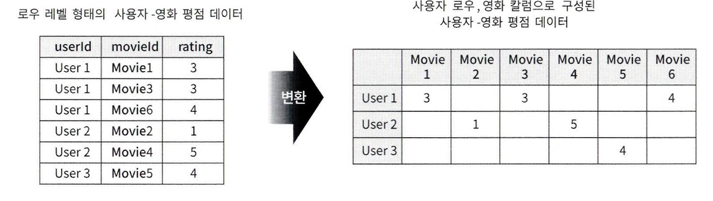

- `pivot_table()` 함수를 사용하여 로우 레벨 데이터를 칼럼 형태로 변환
- `columns='movieId'`를 인자로 주면 `movieId` 값이 새로운 칼럼 이름이 됨
- 예시: `ratings.pivot_table('rating', index='userId', columns='movieId')`  
  → `userId`가 로우로, `movieId`가 칼럼으로 변환되고, 데이터는 `rating` 값을 할당

In [21]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- `pivot_table()` 적용 후 `movieId`가 칼럼명으로 변환되어 NaN 값이 발생
- NaN 값은 사용자가 평점을 매기지 않은 영화에 해당
- 칼럼명을 `movieId` 대신 `title`로 변경하기 위해 `ratings`와 `movies` 데이터 세트를 조인
- `pivot_table()`에서 `columns='title'`을 사용해 영화명으로 피벗
- 이후 NaN 값을 0으로 변환

In [22]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행.
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화 간 유사도 산출

- 영화 간 유사도를 측정하기 위해 `cosine_similarity()`를 사용
- `ratings_matrix`는 사용자-영화 평점 데이터로, 행은 사용자(`userid`), 열은 영화(`movieId`)로 구성됨
- `cosine_similarity()`는 행 기준으로 유사도를 계산하기 때문에, 이를 적용하면 영화 간 유사도가 아닌 사용자 간 유사도가 계산됨

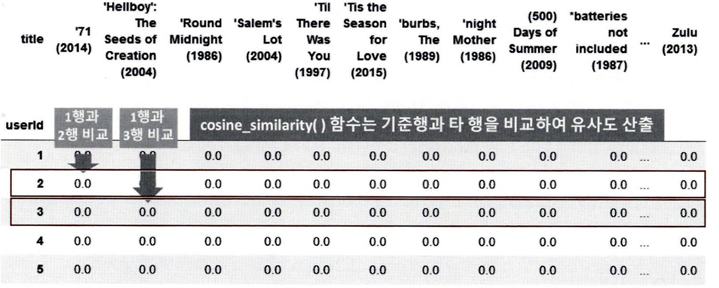

- 영화 기준으로 유사도를 측정하려면 `ratings_matrix`의 행과 열을 바꿔야 함
- 이를 위해 판다스의 `transpose()` 함수를 사용하여 행과 열을 전치시킴

In [23]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- `ratings_matrix`를 전치 행렬로 변환 후, `cosine_similarity()`를 사용해 영화 간 유사도를 계산
- 유사도 값을 영화명과 매핑하여 DataFrame으로 변환

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


- `ratings_matrix.transpose()`에 `cosine_similarity()`를 적용해 영화 유사도 행렬 `item_sim` 생성
- `item_sim`을 DataFrame으로 변환한 `item_sim_df`를 사용하여 영화 '대부(Godfather, The (1972))'와 유사도가 높은 상위 6개 영화 추출

In [25]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


- 기준 영화 '대부'와 가장 유사한 영화는 '대부-2편', 그 뒤로 '좋은 친구들' 등이 유사도 상위
- 장르가 다른 영화들(예: '뻐꾸기 둥지 위로 날아간 새', '스타워즈 1편')도 유사도가 높게 나타남
- '인셉션'과 유사한 영화를 찾아 추천

In [26]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


- '다크나이트'가 '인셉션'과 가장 유사한 영화
- 스릴러, 액션 장르의 영화들이 높은 유사도
- 아이템 기반 유사도 데이터를 이용해 개인화된 영화 추천 알고리즘 개발 예정

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

- 아이템 기반 유사도 데이터는 영화 간 유사도만 반영
- 개인화된 영화 추천은 아직 관람하지 않은 영화를 추천
- 아이템 유사도와 기존 평점을 바탕으로 예측 평점을 계산해 추천

아이템 기반의 협업 필터링에서 개인화된 예측 평점

$$
\hat{R}_{u,i} = \frac{\sum_{n=1}^{N} S_{i,n} \cdot R_{u,n}}{\sum_{n=1}^{N} |S_{i,n}|}
$$

- $ \hat{R}_{u,i} $: 사용자 $ u $의 아이템 $ i $에 대한 개인화된 예측 평점 값
- $ S_{i,n} $: 아이템 $ i $와 가장 유사도가 높은 Top $ N $ 개 아이템의 유사도 벡터
- $ R_{u,n} $: 사용자 $ u $의 아이템 $ n $에 대한 실제 평점 벡터

- N : 아이템의 최근접 이웃 범위 계수로, 특정 아이템과 유사도가 가장 높은 Top-N개의 아이템을 추출하는 데 사용됨
- 모든 아이템을 기준으로 예측 평점을 먼저 구한 뒤, Top-N 아이템을 기반으로 협업 필터링을 적용하는 방식
- `predict_rating()` 함수는 사용자-영화 평점 행렬과 영화 간 유사도를 이용해 개인화된 예측 평점을 계산
- 예측 평점 계산 방식: 사용자별로 모든 영화에 대해 실제 평점과 유사도 벡터 내적 곱을 구하고, 이를 정규화하여 예측 평점으로 사용

In [27]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

- `ratings_arr.dot(item_sim_arr)`: 사용자-영화 평점 행렬과 영화 간 유사도 행렬의 내적을 계산한 값
- `np.array([np.abs(item_sim_arr).sum(axis=1)])`: 유사도 행렬의 절댓값 합을 계산한 값

- `predict_rating()` 함수를 사용하여 개인화된 예측 평점을 계산
- `ratings_matrix`와 `item_sim_df`를 넘파이 행렬로 변환하여 인자로 입력

In [28]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


- 예측 평점은 실제 평점과 코사인 유사도의 내적 값으로 계산
- 영화 관람 기록이 없는 경우에도 예측 평점이 부여됨
- 예측 평점이 실제 평점보다 작을 수 있는 이유는 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문

- 예측 결과와 실제 평점의 차이를 확인하기 위해 MSE를 사용
- 평점을 주지 않은 영화에 대해 예측 평점이 부여되므로, MSE는 평점이 부여된 영화에 대해서만 계산
- MSE를 계산하는 `get_mse()` 함수 구현 후 결과 확인

In [29]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함.
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근점 이웃 MSE:', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근점 이웃 MSE: 9.895354759094706


- MSE 값은 약 9.89로, 실제 값과 예측값의 스케일 차이로 인해 클 수 있음
- 중요한 점은 MSE를 감소시키는 방향으로 모델을 개선하는 것

- `predict_rating_topsim()` 함수는 `n` 인자를 통해 Top-N 유사도 벡터만 적용해 예측값을 계산
- 개별 예측값을 구할 때 for 루프를 반복해야 해서 계산 시간이 오래 걸릴 수 있음
- 현재 데이터 세트에서는 빠르게 수행되지만, 데이터가 커지면 시간이 많이 걸림

In [30]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
  pred = np.zeros(ratings_arr.shape)

  # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행.
  for col in range(ratings_arr.shape[1]):
    # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
    top_n_items = [np.argsort(item_sim_arr[:, col])[-n-1:-1]]
    # 개인화된 예측 평점을 계산
    for row in range(ratings_arr.shape[0]):
      pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T)
      pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))

  return pred

- `predict_rating_topsim()` 함수를 사용해 예측 평점을 계산하고, 실제 평점과의 MSE를 구함
- 계산된 예측 평점 넘파이 행렬을 판다스 DataFrame으로 변환

In [31]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 Top-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index, columns = ratings_matrix.columns)

아이템 기반 최근접 Top-20 이웃 MSE:  4.54938079005833


- `userid = 9`인 사용자가 평점을 준 영화를 평점이 높은 순으로 나열하여 확인

In [32]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id > 0].sort_values(ascending=False)[:10]

,9
title,
Adaptation (2002),5.0
Austin Powers in Goldmember (2002),5.0
Back to the Future (1985),5.0
Citizen Kane (1941),5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Producers, The (1968)",5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
Elling (2001),4.0


- `get_unseen_movies()` 함수는 사용자가 평점을 주지 않은 영화를 반환
- 이미 평점을 준 영화는 제외하고 추천할 영화만 필터링

In [33]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함.
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임.
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듦.
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듦.
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함.
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

- `recomm_movie_by_userid()` 함수는 사용자별 예측 평점과 추천 후보 영화를 바탕으로 최상위 예측 평점을 가진 영화를 추천
- 인자: 예측 평점 DataFrame, 사용자 ID, 추천 후보 영화 리스트, 추천 상위 영화 개수

In [34]:
def recomm_movie_by_userId(pred_df, userId, unseen_list, top_n=10):
  # 예측 평점 DataFrame에서 사용자id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬함.
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userId(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성.
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_score'])
recomm_movies

,pred_score
title,
Gladiator (2000),0.958652
Shrek (2001),0.897386
Spider-Man (2002),0.887775
"Last Samurai, The (2003)",0.854397
Indiana Jones and the Temple of Doom (1984),0.844384
"Matrix Reloaded, The (2003)",0.830102
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.794363
"Matrix, The (1999)",0.757196
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.712107


- 추천된 영화: ‘슈렉’, ‘스파이더 맨’, ‘인디아나 존스-2편’, ‘매트릭스’ 등 높은 흥행성의 작품